In [108]:
# Basic imports
import cv2
import os
import numpy as np
import matplotlib.pyplot as plt

print("Libraries loaded successfully")


Libraries loaded successfully


In [109]:
video_path = "/content/drive/MyDrive/CSE463_LAB_I O/Project_Folder/Input/Project_Sample.mp4"
print("Using video:", video_path)


Using video: /content/drive/MyDrive/CSE463_LAB_I O/Project_Folder/Input/Project_Sample.mp4


In [110]:
def extract_frames(video_path, frame_skip=10, resize=(224, 224)):
    cap = cv2.VideoCapture(video_path)
    frames = []
    frame_count = 0

    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break

        if frame_count % frame_skip == 0:
            frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
            frame = cv2.resize(frame, resize)
            frames.append(frame)

        frame_count += 1

    cap.release()
    return np.array(frames)

frames = extract_frames(video_path, frame_skip=10)
print("Sampled frames:", frames.shape)


Sampled frames: (205, 224, 224, 3)


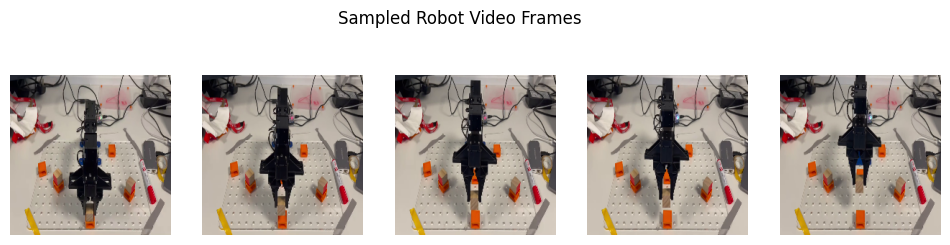

In [111]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,3))
for i in range(5):
    plt.subplot(1,5,i+1)
    plt.imshow(frames[i])
    plt.axis("off")
plt.suptitle("Sampled Robot Video Frames")
plt.show()


In [112]:
import torch
import torchvision.models as models
import torchvision.transforms as transforms

print("Torch version:", torch.__version__)


Torch version: 2.9.0+cu126


In [113]:
# Load pretrained ResNet-18
model = models.resnet18(pretrained=True)

# Remove classification head
model = torch.nn.Sequential(*list(model.children())[:-1])

# Freeze weights
for param in model.parameters():
    param.requires_grad = False

model.eval()

device = torch.device("cpu")
model = model.to(device)

print("Model loaded and frozen")


Model loaded and frozen


In [114]:
preprocess = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])


In [115]:
# Convert numpy frames to torch tensors
frame_tensors = torch.stack([
    preprocess(frame) for frame in frames
]).to(device)

print("Frame tensor shape:", frame_tensors.shape)


Frame tensor shape: torch.Size([205, 3, 224, 224])


In [116]:
def extract_embeddings(model, frames, batch_size=16):
    embeddings = []

    with torch.no_grad():
        for i in range(0, len(frames), batch_size):
            batch = frames[i:i+batch_size]
            features = model(batch)
            features = features.squeeze(-1).squeeze(-1)
            embeddings.append(features.cpu())

    return torch.cat(embeddings)

embeddings = extract_embeddings(model, frame_tensors)
print("Embedding shape:", embeddings.shape)


Embedding shape: torch.Size([205, 512])


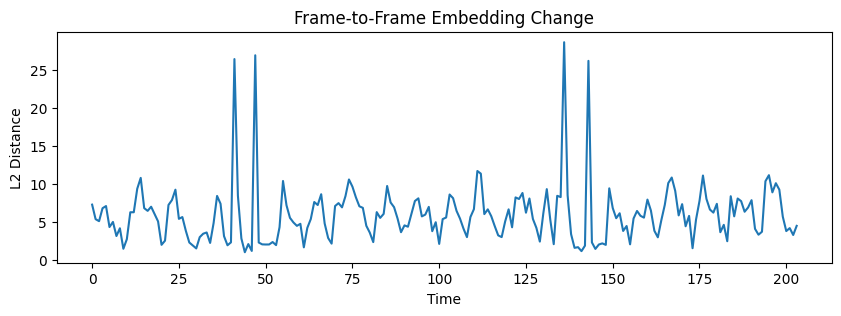

In [117]:
import numpy as np
import matplotlib.pyplot as plt

# Compute frame-to-frame embedding difference
diffs = np.linalg.norm(
    embeddings[1:].numpy() - embeddings[:-1].numpy(),
    axis=1
)

plt.figure(figsize=(10,3))
plt.plot(diffs)
plt.title("Frame-to-Frame Embedding Change")
plt.xlabel("Time")
plt.ylabel("L2 Distance")
plt.show()


In [118]:
import numpy as np

# Convert embeddings to numpy
E = embeddings.numpy()

# Frame-to-frame embedding distance
change_signal = np.linalg.norm(E[1:] - E[:-1], axis=1)

print("Change signal shape:", change_signal.shape)


Change signal shape: (204,)


In [119]:
from scipy.ndimage import gaussian_filter1d

smoothed_signal = gaussian_filter1d(change_signal, sigma=1)


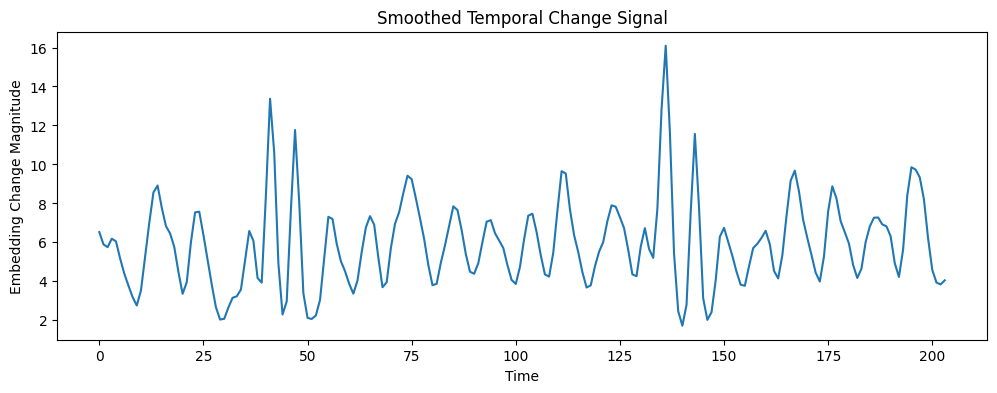

In [120]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,4))
plt.plot(smoothed_signal)
plt.title("Smoothed Temporal Change Signal")
plt.xlabel("Time")
plt.ylabel("Embedding Change Magnitude")
plt.show()


In [121]:
from scipy.signal import find_peaks

peaks, properties = find_peaks(
    smoothed_signal,
    height=np.percentile(smoothed_signal, 50),
    distance=2,            # minimum frames between skills
    prominence=0.1         # controls importance of peak
)

boundary_indices = peaks



In [122]:
def clean_boundaries(indices, min_gap=10):
    clean = []
    last = -min_gap
    for idx in indices:
        if idx - last >= min_gap:
            clean.append(idx)
            last = idx
    return clean

skill_boundaries = clean_boundaries(boundary_indices, min_gap=10)
print("Final skill boundaries:", skill_boundaries)


Final skill boundaries: [np.int64(3), np.int64(14), np.int64(24), np.int64(36), np.int64(47), np.int64(65), np.int64(85), np.int64(104), np.int64(123), np.int64(136), np.int64(150), np.int64(160), np.int64(176), np.int64(187)]


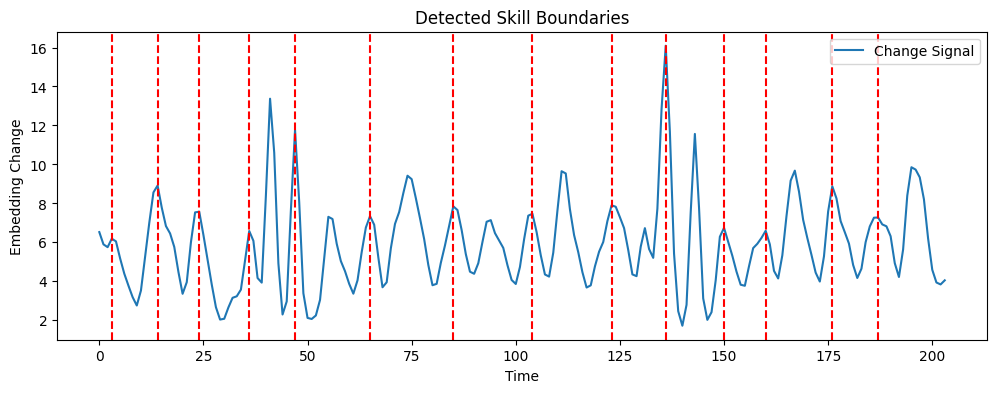

In [123]:
plt.figure(figsize=(12,4))
plt.plot(smoothed_signal, label="Change Signal")

for b in skill_boundaries:
    plt.axvline(b, color="red", linestyle="--")

plt.title("Detected Skill Boundaries")
plt.xlabel("Time")
plt.ylabel("Embedding Change")
plt.legend()
plt.show()


In [124]:
segments = []
start = 0

for b in skill_boundaries:
    segments.append((start, b))
    start = b + 1

segments.append((start, len(E) - 1))

print("Skill segments:")
for i, seg in enumerate(segments):
    print(f"Skill {i+1}: frames {seg[0]} to {seg[1]}")


Skill segments:
Skill 1: frames 0 to 3
Skill 2: frames 4 to 14
Skill 3: frames 15 to 24
Skill 4: frames 25 to 36
Skill 5: frames 37 to 47
Skill 6: frames 48 to 65
Skill 7: frames 66 to 85
Skill 8: frames 86 to 104
Skill 9: frames 105 to 123
Skill 10: frames 124 to 136
Skill 11: frames 137 to 150
Skill 12: frames 151 to 160
Skill 13: frames 161 to 176
Skill 14: frames 177 to 187
Skill 15: frames 188 to 204


In [125]:
!pip install -q ftfy regex tqdm
!pip install -q git+https://github.com/openai/CLIP.git

import clip
import torch

device = "cuda" if torch.cuda.is_available() else "cpu"
model_clip, preprocess_clip = clip.load("ViT-B/32", device=device)
print("CLIP loaded on", device)


  Preparing metadata (setup.py) ... done
CLIP loaded on cuda


In [126]:
skill_texts = [
    "robot arm moving toward an object",
    "robot aligning gripper with object",
    "robot slowing down near object",
    "robot closing gripper",
    "robot grasping object",
    "robot stabilizing grasp",
    "robot lifting object slightly",
    "robot lifting object upward",
    "robot holding an object without moving"
    "robot carrying object",
    "robot moving object laterally",
    "robot lowering object",
    "robot placing object on surface"
    "robot opening gripper",
    "robot releasing object",
    "robot retracting arm"
]


text_tokens = clip.tokenize(skill_texts).to(device)
with torch.no_grad():
    text_embeddings = model_clip.encode_text(text_tokens)
    text_embeddings /= text_embeddings.norm(dim=-1, keepdim=True)


In [127]:
# from PIL import Image

# # segment_embeddings = []

# for seg in segments:
#     start, end = seg
#     frames_seg = []

#     for i in range(start, end+1):
#         # Convert numpy array to PIL
#         pil_img = Image.fromarray(frames[i])
#         # Preprocess for CLIP
#         frames_seg.append(preprocess_clip(pil_img).unsqueeze(0).to(device))

#     frames_seg_tensor = torch.cat(frames_seg)

#     with torch.no_grad():
#         vis_emb = model_clip.encode_image(frames_seg_tensor)
#         vis_emb /= vis_emb.norm(dim=-1, keepdim=True)
#         # seg_emb = vis_emb.mean(dim=0, keepdim=True)
#         # segment_embeddings.append(seg_emb)

# #segment_embeddings = torch.cat(segment_embeddings)
# 3print("Segment embeddings shape:", segment_embeddings.shape)


In [128]:
# # similarity = (segment_embeddings @ text_embeddings.T).cpu().numpy()
# # labels = [skill_texts[i] for i in similarity.argmax(axis=1)]

# for i, label in enumerate(labels):
#     print(f"Skill {i+1} ({segments[i][0]}-{segments[i][1]} frames): {label}")


In [129]:
from collections import Counter

labels = []

for seg in segments:
    start, end = seg
    frames_seg = []

    for i in range(start, end + 1):
        pil_img = Image.fromarray(frames[i])
        frames_seg.append(preprocess_clip(pil_img).unsqueeze(0).to(device))

    frames_seg_tensor = torch.cat(frames_seg)

    with torch.no_grad():
        vis_emb = model_clip.encode_image(frames_seg_tensor)
        vis_emb /= vis_emb.norm(dim=-1, keepdim=True)

        # Frame-wise similarity
        sims = vis_emb @ text_embeddings.T   # [num_frames, num_texts]

        frame_labels = sims.argmax(dim=1).cpu().numpy()
        frame_scores = sims.max(dim=1).values.cpu().numpy()

    # Majority vote
    label_idx = Counter(frame_labels).most_common(1)[0][0]
    confidence = frame_scores.mean()

    if confidence < 0.25:
        labels.append("transition / unknown")
    else:
        labels.append(skill_texts[label_idx])


In [130]:
for i, label in enumerate(labels):
    print(f"Skill {i+1} ({segments[i][0]}-{segments[i][1]} frames): {label}")


Skill 1 (0-3 frames): robot aligning gripper with object
Skill 2 (4-14 frames): robot aligning gripper with object
Skill 3 (15-24 frames): robot placing object on surfacerobot opening gripper
Skill 4 (25-36 frames): robot placing object on surfacerobot opening gripper
Skill 5 (37-47 frames): robot aligning gripper with object
Skill 6 (48-65 frames): robot placing object on surfacerobot opening gripper
Skill 7 (66-85 frames): robot placing object on surfacerobot opening gripper
Skill 8 (86-104 frames): robot placing object on surfacerobot opening gripper
Skill 9 (105-123 frames): robot placing object on surfacerobot opening gripper
Skill 10 (124-136 frames): robot arm moving toward an object
Skill 11 (137-150 frames): robot placing object on surfacerobot opening gripper
Skill 12 (151-160 frames): robot placing object on surfacerobot opening gripper
Skill 13 (161-176 frames): robot aligning gripper with object
Skill 14 (177-187 frames): robot placing object on surfacerobot opening grippe

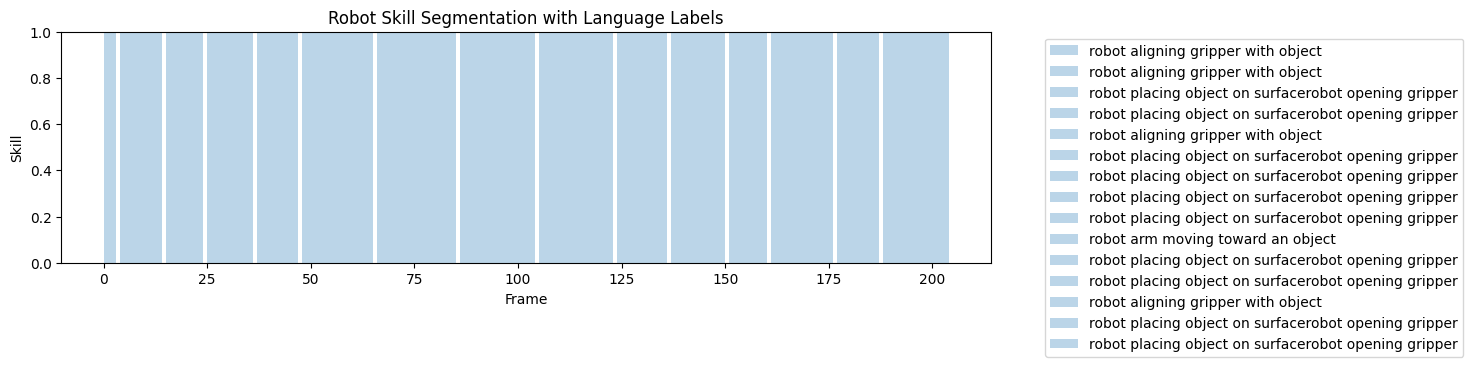

In [131]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,3))
for i, seg in enumerate(segments):
    plt.axvspan(seg[0], seg[1], alpha=0.3, label=labels[i])

plt.title("Robot Skill Segmentation with Language Labels")
plt.xlabel("Frame")
plt.ylabel("Skill")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()


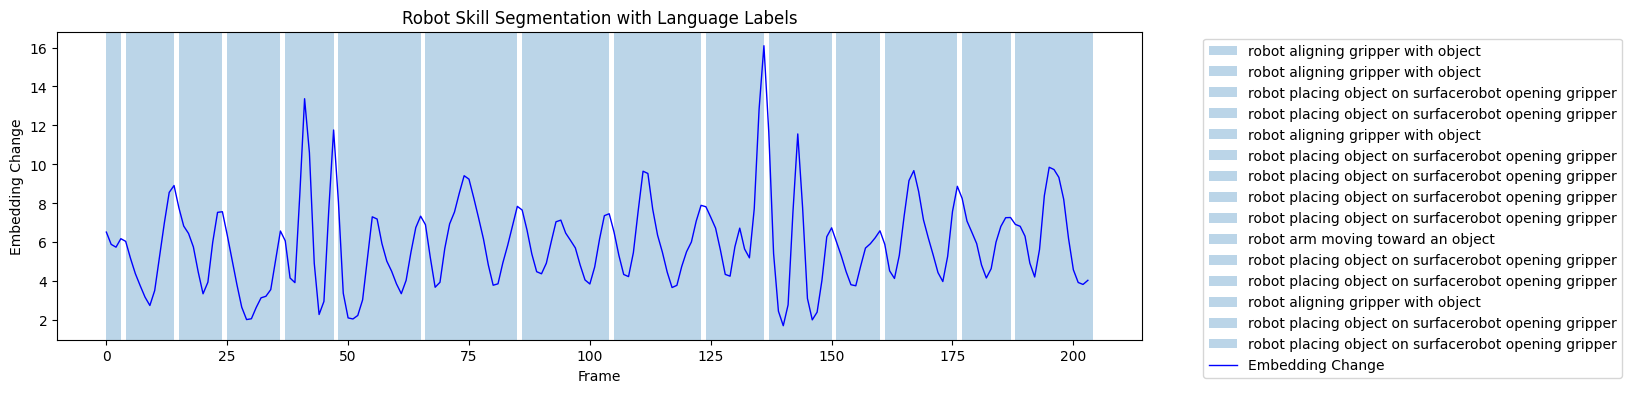

In [132]:
plt.figure(figsize=(14,4))
for i, seg in enumerate(segments):
    plt.axvspan(seg[0], seg[1], alpha=0.3, label=labels[i])

plt.plot(smoothed_signal, color='blue', linewidth=1, label='Embedding Change')
plt.title("Robot Skill Segmentation with Language Labels")
plt.xlabel("Frame")
plt.ylabel("Embedding Change")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()


In [133]:
out_path = "robot_skills_labeled.mp4"
fourcc = cv2.VideoWriter_fourcc(*'mp4v')
h, w, _ = frames[0].shape
out = cv2.VideoWriter(out_path, fourcc, 10, (w, h))

for i, frame in enumerate(frames):
    frame_bgr = cv2.cvtColor(frame, cv2.COLOR_RGB2BGR)
    # Find current skill label
    current_label = ""
    for idx, seg in enumerate(segments):
        if seg[0] <= i <= seg[1]:
            current_label = labels[idx]
            break
    # Put label on frame
    cv2.putText(frame_bgr, current_label, (10,30),
                cv2.FONT_HERSHEY_SIMPLEX, 0.8, (0,0,255), 2)
    out.write(frame_bgr)

out.release()
print("Labeled video saved as:", out_path)


Labeled video saved as: robot_skills_labeled.mp4


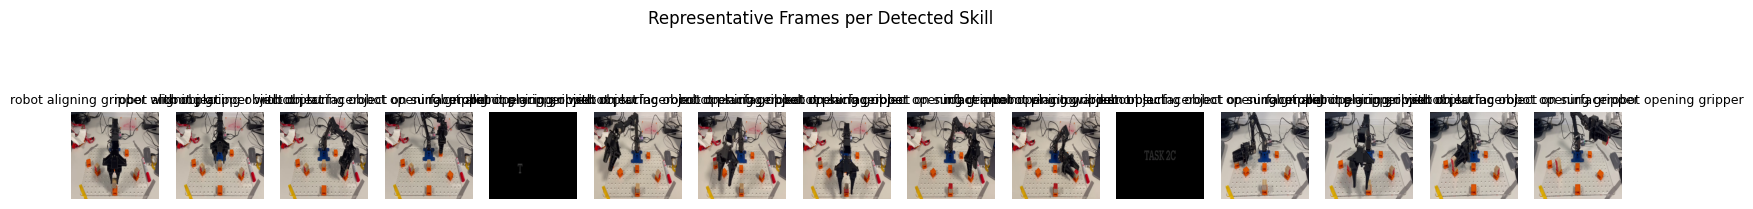

In [134]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,3))
for i, seg in enumerate(segments):
    # Pick middle frame of the segment
    mid_frame_idx = (seg[0] + seg[1]) // 2
    frame = frames[mid_frame_idx]

    plt.subplot(1, len(segments), i+1)
    plt.imshow(frame)
    plt.axis("off")
    plt.title(labels[i], fontsize=9)

plt.suptitle("Representative Frames per Detected Skill", fontsize=12)
plt.show()


In [135]:
from PIL import Image, ImageDraw, ImageFont

frames_gif = []
for i, frame in enumerate(frames):
    pil_img = Image.fromarray(frame)
    draw = ImageDraw.Draw(pil_img)
    for idx, seg in enumerate(segments):
        if seg[0] <= i <= seg[1]:
            label = labels[idx]
            break
    draw.text((10,10), label, fill=(255,0,0))
    frames_gif.append(pil_img)

frames_gif[0].save("robot_skills.gif",
                   save_all=True,
                   append_images=frames_gif[1:],
                   duration=100, loop=0)
print("GIF saved as robot_skills.gif")


GIF saved as robot_skills.gif


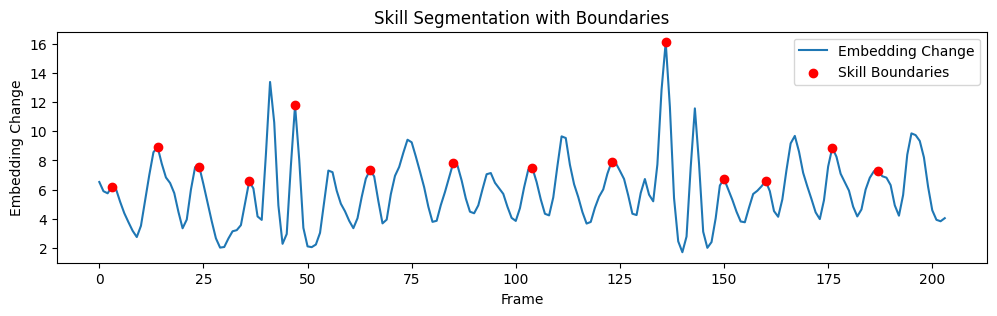

In [136]:
plt.figure(figsize=(12,3))
plt.plot(smoothed_signal, label="Embedding Change")
plt.scatter(skill_boundaries, smoothed_signal[skill_boundaries], color='red', zorder=5, label="Skill Boundaries")
plt.title("Skill Segmentation with Boundaries")
plt.xlabel("Frame")
plt.ylabel("Embedding Change")
plt.legend()
plt.show()


In [137]:
frame_labels = []
frame_scores = []

with torch.no_grad():
    for i in range(len(frames)):
        pil_img = Image.fromarray(frames[i])
        img_tensor = preprocess_clip(pil_img).unsqueeze(0).to(device)

        vis_emb = model_clip.encode_image(img_tensor)
        vis_emb /= vis_emb.norm(dim=-1, keepdim=True)

        sims = (vis_emb @ text_embeddings.T).squeeze(0)
        label_idx = sims.argmax().item()
        score = sims.max().item()

        frame_labels.append(skill_texts[label_idx])
        frame_scores.append(score)


In [138]:
gt_frame_labels = [None] * len(frames)

for seg_idx, (start, end) in enumerate(segments):
    seg_label = labels[seg_idx]   # your segment label
    for i in range(start, end + 1):
        gt_frame_labels[i] = seg_label


In [139]:
correct = 0
total = 0

for i in range(len(frames)):
    if frame_labels[i] == gt_frame_labels[i]:
        correct += 1
    total += 1

accuracy = correct / total
print(f"Frame-to-segment agreement accuracy: {accuracy*100:.2f}%")


Frame-to-segment agreement accuracy: 60.00%


In [140]:
confident_frames = [s for s in frame_scores if s > 0.28]
confidence_accuracy = len(confident_frames) / len(frame_scores)

print(f"High-confidence frame ratio: {confidence_accuracy*100:.2f}%")


High-confidence frame ratio: 93.66%


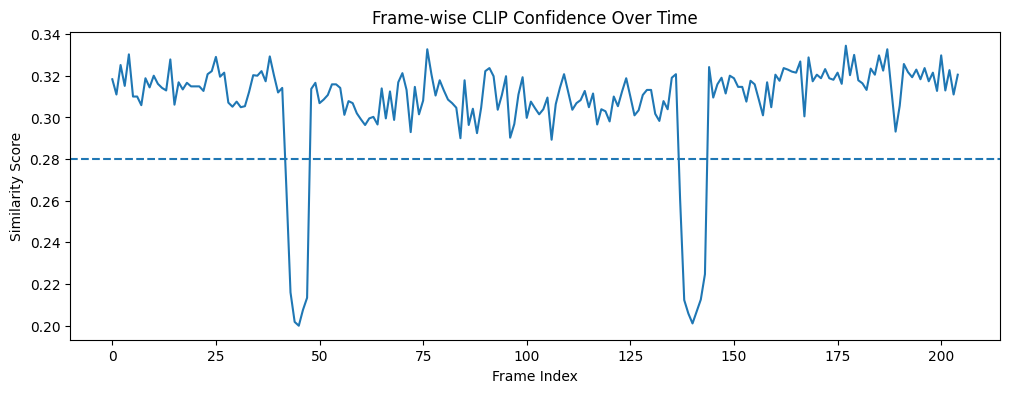

In [141]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,4))
plt.plot(frame_scores)
plt.axhline(0.28, linestyle='--')
plt.title("Frame-wise CLIP Confidence Over Time")
plt.xlabel("Frame Index")
plt.ylabel("Similarity Score")
plt.show()


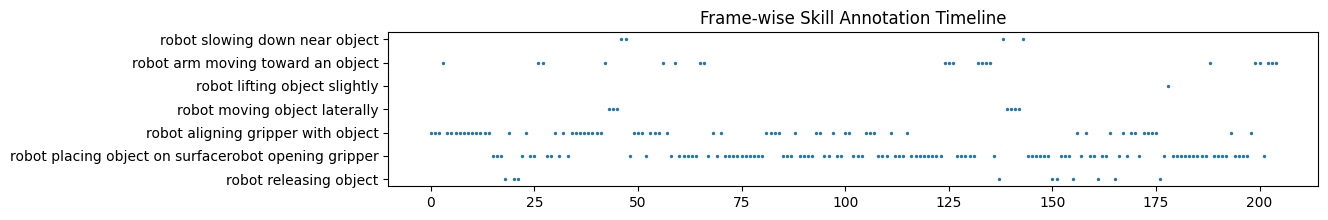

In [142]:
unique_skills = list(set(frame_labels))
skill_to_id = {s:i for i,s in enumerate(unique_skills)}
skill_ids = [skill_to_id[s] for s in frame_labels]

plt.figure(figsize=(12,2))
plt.scatter(range(len(skill_ids)), skill_ids, s=2)
plt.yticks(list(skill_to_id.values()), list(skill_to_id.keys()))
plt.title("Frame-wise Skill Annotation Timeline")
plt.show()


In [143]:
from collections import Counter

for idx, (start, end) in enumerate(segments):
    seg_frame_labels = frame_labels[start:end+1]
    counts = Counter(seg_frame_labels)

    print(f"Skill {idx+1} ({start}-{end}):")
    for k, v in counts.most_common(2):
        print(f"  {k} ({v/(end-start+1)*100:.1f}%)")


Skill 1 (0-3):
  robot aligning gripper with object (75.0%)
  robot arm moving toward an object (25.0%)
Skill 2 (4-14):
  robot aligning gripper with object (100.0%)
Skill 3 (15-24):
  robot placing object on surfacerobot opening gripper (50.0%)
  robot releasing object (30.0%)
Skill 4 (25-36):
  robot placing object on surfacerobot opening gripper (41.7%)
  robot aligning gripper with object (41.7%)
Skill 5 (37-47):
  robot aligning gripper with object (45.5%)
  robot moving object laterally (27.3%)
Skill 6 (48-65):
  robot placing object on surfacerobot opening gripper (44.4%)
  robot aligning gripper with object (38.9%)
Skill 7 (66-85):
  robot placing object on surfacerobot opening gripper (65.0%)
  robot aligning gripper with object (30.0%)
Skill 8 (86-104):
  robot placing object on surfacerobot opening gripper (68.4%)
  robot aligning gripper with object (31.6%)
Skill 9 (105-123):
  robot placing object on surfacerobot opening gripper (73.7%)
  robot aligning gripper with object